In [56]:
# import modin.pandas as pd
import pandas as pd
import datetime
import math
import warnings
warnings.filterwarnings("ignore")
data_sets = {
    'ADABTC_3m': None,
    'XRPBTC_15m': None
}

ts = pd.read_csv('/Users/gabeheim/documents/repos/bender/source files/ADABTC_3m.csv', index_col=False)#.set_index('Open time')
for time in ['Open time', 'Close time']:
    ts[time].divide(10000)
    ts[time] = pd.to_datetime(ts[time]/1000,unit='s')

data = ts[:math.floor(len(ts)/4)]
data = data.reindex(index=data.index[::-1]).reset_index().drop(['index'], axis=1)
# data = data[7 * math.floor(len(ts) / 8):]
data

,Open time,Open,High,Low,Close,Volume,Close time,Number of trades
0,2018-02-23 00:51:00,0.000031,0.000031,0.000031,0.000031,263074.0,2018-02-23 00:53:59.999000072,134
1,2018-02-23 00:48:00,0.000031,0.000031,0.000031,0.000031,711500.0,2018-02-23 00:50:59.999000072,322
2,2018-02-23 00:45:00,0.000031,0.000031,0.000031,0.000031,305714.0,2018-02-23 00:47:59.999000072,229
3,2018-02-23 00:42:00,0.000031,0.000031,0.000031,0.000031,164274.0,2018-02-23 00:44:59.999000072,187
4,2018-02-23 00:39:00,0.000032,0.000032,0.000031,0.000031,264383.0,2018-02-23 00:41:59.999000072,117
...,...,...,...,...,...,...,...,...
39815,2017-11-30 12:39:00,0.000011,0.000012,0.000011,0.000012,559204.0,2017-11-30 12:41:59.999000072,81
39816,2017-11-30 12:36:00,0.000069,0.000069,0.000011,0.000011,366164.0,2017-11-30 12:38:59.999000072,68
39817,2017-11-30 12:33:00,0.000089,0.000089,0.000050,0.000050,39753.0,2017-11-30 12:35:59.999000072,34
39818,2017-11-30 12:30:00,0.000009,0.000009,0.000009,0.000009,0.0,2017-11-30 12:32:59.999000072,0


In [57]:
import numba

count = 0
def labels(row, target_percent, stop_loss_percent):
#     print(row)
    global count
    count += 1
    try:
        target_index = data.loc[row._name:][data.Close >= row.Close * (1 + target_percent)].iloc[0]._name
    except IndexError:
        target_index = data.index.max() + 5
    try:
        stop_loss_index = data.loc[row._name:][data.Close <= row.Close * (1 - target_percent)].iloc[0]._name
    except IndexError:
        stop_loss_index = data.index.max() + 5
    if target_index > stop_loss_index:
        return 0
    elif target_index < stop_loss_index:
        return 1
    return None

data['label'] = data.apply(lambda row: labels(row, .05, .01), axis=1)# engine='numba') # ,
# data['label'] = pd.Series(labels(row, .05, .01) for row in data.itertuples())
data

,Open time,Open,High,Low,Close,Volume,Close time,Number of trades,label
0,2018-02-23 00:51:00,0.000031,0.000031,0.000031,0.000031,263074.0,2018-02-23 00:53:59.999000072,134,1.0
1,2018-02-23 00:48:00,0.000031,0.000031,0.000031,0.000031,711500.0,2018-02-23 00:50:59.999000072,322,1.0
2,2018-02-23 00:45:00,0.000031,0.000031,0.000031,0.000031,305714.0,2018-02-23 00:47:59.999000072,229,1.0
3,2018-02-23 00:42:00,0.000031,0.000031,0.000031,0.000031,164274.0,2018-02-23 00:44:59.999000072,187,1.0
4,2018-02-23 00:39:00,0.000032,0.000032,0.000031,0.000031,264383.0,2018-02-23 00:41:59.999000072,117,1.0
...,...,...,...,...,...,...,...,...,...
39815,2017-11-30 12:39:00,0.000011,0.000012,0.000011,0.000012,559204.0,2017-11-30 12:41:59.999000072,81,1.0
39816,2017-11-30 12:36:00,0.000069,0.000069,0.000011,0.000011,366164.0,2017-11-30 12:38:59.999000072,68,1.0
39817,2017-11-30 12:33:00,0.000089,0.000089,0.000050,0.000050,39753.0,2017-11-30 12:35:59.999000072,34,0.0
39818,2017-11-30 12:30:00,0.000009,0.000009,0.000009,0.000009,0.0,2017-11-30 12:32:59.999000072,0,NaN


In [58]:
count

39820

In [30]:
import talib as ta

data['sma_10'] = ta.SMA(data.Close, timeperiod=10)
macd, macd_signal, macd_hist = ta.MACDFIX(data.Close, signalperiod=9)
data['macd'] = macd
data['macd_signal'] = macd_signal
data['macd_hist'] = macd_hist
data['cci_24'] = ta.CCI(data.High, data.Low, data.Close, timeperiod=24)
data['mom_10'] = ta.MOM(data.Close, timeperiod=10)
data['roc_10'] = ta.ROC(data.Close, timeperiod=10)
data['rsi_5'] = ta.RSI(data.Close, timeperiod=5)
data['wnr_9'] = ta.WILLR(data.High, data.Low, data.Close, timeperiod=9)
slowk, slowd = ta.STOCH(data.High, data.Low, data.Close, fastk_period=5, 
                        slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
data['slowk'] = slowk
data['slowd'] = slowd
data['adosc'] = ta.ADOSC(data.High, data.Low, data.Close, data.Volume, fastperiod=3, slowperiod=10)
# ar, br, vr .. (26), bias 20
data

,Open time,Open,High,Low,Close,Volume,Close time,Number of trades,label,sma_10,...,macd_signal,macd_hist,cci_24,mom_10,roc_10,rsi_5,wnr_9,slowk,slowd,adosc
0,2017-11-30 12:27:00,0.000009,0.000009,0.000009,0.000009,1064.0,2017-11-30 12:29:59.999000072,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-11-30 12:30:00,0.000009,0.000009,0.000009,0.000009,0.0,2017-11-30 12:32:59.999000072,0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-11-30 12:33:00,0.000089,0.000089,0.000050,0.000050,39753.0,2017-11-30 12:35:59.999000072,34,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-11-30 12:36:00,0.000069,0.000069,0.000011,0.000011,366164.0,2017-11-30 12:38:59.999000072,68,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-11-30 12:39:00,0.000011,0.000012,0.000011,0.000012,559204.0,2017-11-30 12:41:59.999000072,81,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39815,2018-02-23 00:39:00,0.000032,0.000032,0.000031,0.000031,264383.0,2018-02-23 00:41:59.999000072,117,NaN,0.000032,...,-2.069673e-08,-2.086991e-08,-152.804763,-1.900000e-07,-0.600316,24.070670,-76.000000,23.750000,18.326720,53053.434863
39816,2018-02-23 00:42:00,0.000031,0.000031,0.000031,0.000031,164274.0,2018-02-23 00:44:59.999000072,187,NaN,0.000032,...,-2.603709e-08,-2.136143e-08,-180.111924,-2.000000e-07,-0.632311,19.592361,-61.764706,39.722222,27.010582,76553.533651
39817,2018-02-23 00:45:00,0.000031,0.000031,0.000031,0.000031,305714.0,2018-02-23 00:47:59.999000072,229,NaN,0.000031,...,-3.186980e-08,-2.333081e-08,-201.842375,-2.700000e-07,-0.853081,14.119595,-52.173913,50.687135,38.053119,140453.532284
39818,2018-02-23 00:48:00,0.000031,0.000031,0.000031,0.000031,711500.0,2018-02-23 00:50:59.999000072,322,NaN,0.000031,...,-3.793863e-08,-2.427535e-08,-189.695443,-2.500000e-07,-0.790889,12.389242,-45.833333,57.988722,49.466026,295317.415154


In [31]:
from sklearn.preprocessing import minmax_scale

indicators = ['sma_10','macd','macd_signal','macd_hist','cci_24','mom_10','roc_10','rsi_5','wnr_9','slowk','slowd','adosc']
min_mix_indicators = ['Volume', 'Number of trades','sma_10','rsi_5','wnr_9','slowk','slowd','adosc']
for indicator in min_mix_indicators:
    data[indicator + '_min_max'] = minmax_scale(data[indicator])
data

,Open time,Open,High,Low,Close,Volume,Close time,Number of trades,label,sma_10,...,slowd,adosc,Volume_min_max,Number of trades_min_max,sma_10_min_max,rsi_5_min_max,wnr_9_min_max,slowk_min_max,slowd_min_max,adosc_min_max
0,2017-11-30 12:27:00,0.000009,0.000009,0.000009,0.000009,1064.0,2017-11-30 12:29:59.999000072,1,1.0,NaN,...,NaN,NaN,0.000159,0.000332,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-11-30 12:30:00,0.000009,0.000009,0.000009,0.000009,0.0,2017-11-30 12:32:59.999000072,0,1.0,NaN,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-11-30 12:33:00,0.000089,0.000089,0.000050,0.000050,39753.0,2017-11-30 12:35:59.999000072,34,0.0,NaN,...,NaN,NaN,0.005931,0.011273,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-11-30 12:36:00,0.000069,0.000069,0.000011,0.000011,366164.0,2017-11-30 12:38:59.999000072,68,1.0,NaN,...,NaN,NaN,0.054633,0.022546,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-11-30 12:39:00,0.000011,0.000012,0.000011,0.000012,559204.0,2017-11-30 12:41:59.999000072,81,1.0,NaN,...,NaN,NaN,0.083436,0.026857,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39815,2018-02-23 00:39:00,0.000032,0.000032,0.000031,0.000031,264383.0,2018-02-23 00:41:59.999000072,117,NaN,0.000032,...,18.326720,53053.434863,0.039447,0.038793,0.316188,0.240844,0.240000,0.237500,0.183267,0.273382
39816,2018-02-23 00:42:00,0.000031,0.000031,0.000031,0.000031,164274.0,2018-02-23 00:44:59.999000072,187,NaN,0.000032,...,27.010582,76553.533651,0.024510,0.062003,0.315942,0.196035,0.382353,0.397222,0.270106,0.276407
39817,2018-02-23 00:45:00,0.000031,0.000031,0.000031,0.000031,305714.0,2018-02-23 00:47:59.999000072,229,NaN,0.000031,...,38.053119,140453.532284,0.045614,0.075928,0.315610,0.141276,0.478261,0.506871,0.380531,0.284634
39818,2018-02-23 00:48:00,0.000031,0.000031,0.000031,0.000031,711500.0,2018-02-23 00:50:59.999000072,322,NaN,0.000031,...,49.466026,295317.415154,0.106159,0.106764,0.315302,0.123963,0.541667,0.579887,0.494660,0.304573


In [32]:
polarize_indicators = ['macd','macd_signal','macd_hist','cci_24','mom_10','roc_10', 'wnr_9','adosc']
for indicator in polarize_indicators:
    data[indicator + '_polarize'] = data[indicator] / abs(data[indicator])
data

,Open time,Open,High,Low,Close,Volume,Close time,Number of trades,label,sma_10,...,slowd_min_max,adosc_min_max,macd_polarize,macd_signal_polarize,macd_hist_polarize,cci_24_polarize,mom_10_polarize,roc_10_polarize,wnr_9_polarize,adosc_polarize
0,2017-11-30 12:27:00,0.000009,0.000009,0.000009,0.000009,1064.0,2017-11-30 12:29:59.999000072,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-11-30 12:30:00,0.000009,0.000009,0.000009,0.000009,0.0,2017-11-30 12:32:59.999000072,0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-11-30 12:33:00,0.000089,0.000089,0.000050,0.000050,39753.0,2017-11-30 12:35:59.999000072,34,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-11-30 12:36:00,0.000069,0.000069,0.000011,0.000011,366164.0,2017-11-30 12:38:59.999000072,68,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-11-30 12:39:00,0.000011,0.000012,0.000011,0.000012,559204.0,2017-11-30 12:41:59.999000072,81,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39815,2018-02-23 00:39:00,0.000032,0.000032,0.000031,0.000031,264383.0,2018-02-23 00:41:59.999000072,117,NaN,0.000032,...,0.183267,0.273382,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
39816,2018-02-23 00:42:00,0.000031,0.000031,0.000031,0.000031,164274.0,2018-02-23 00:44:59.999000072,187,NaN,0.000032,...,0.270106,0.276407,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
39817,2018-02-23 00:45:00,0.000031,0.000031,0.000031,0.000031,305714.0,2018-02-23 00:47:59.999000072,229,NaN,0.000031,...,0.380531,0.284634,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
39818,2018-02-23 00:48:00,0.000031,0.000031,0.000031,0.000031,711500.0,2018-02-23 00:50:59.999000072,322,NaN,0.000031,...,0.494660,0.304573,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0


In [33]:
percentage_indicators = ['sma_10','mom_10','roc_10','rsi_5','slowk','slowd']
for indicator in percentage_indicators:
    
    data[indicator + '_percentage'] = data[indicator].pct_change()  
    data[indicator + '_percentage'] = ( (data[indicator + '_percentage'] - data[indicator + '_percentage'].min()) / 
                                       (data[indicator + '_percentage'].max() - data[indicator + '_percentage'].min()) ) * (1 - -1) + -1 
    
    #minmax_scale(data[indicator].pct_change(), feature_range=(-1, 1))
data

,Open time,Open,High,Low,Close,Volume,Close time,Number of trades,label,sma_10,...,mom_10_polarize,roc_10_polarize,wnr_9_polarize,adosc_polarize,sma_10_percentage,mom_10_percentage,roc_10_percentage,rsi_5_percentage,slowk_percentage,slowd_percentage
0,2017-11-30 12:27:00,0.000009,0.000009,0.000009,0.000009,1064.0,2017-11-30 12:29:59.999000072,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-11-30 12:30:00,0.000009,0.000009,0.000009,0.000009,0.0,2017-11-30 12:32:59.999000072,0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-11-30 12:33:00,0.000089,0.000089,0.000050,0.000050,39753.0,2017-11-30 12:35:59.999000072,34,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-11-30 12:36:00,0.000069,0.000069,0.000011,0.000011,366164.0,2017-11-30 12:38:59.999000072,68,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-11-30 12:39:00,0.000011,0.000012,0.000011,0.000012,559204.0,2017-11-30 12:41:59.999000072,81,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39815,2018-02-23 00:39:00,0.000032,0.000032,0.000031,0.000031,264383.0,2018-02-23 00:41:59.999000072,117,NaN,0.000032,...,-1.0,-1.0,-1.0,1.0,0.781956,NaN,NaN,-1.0,-1.0,-1.0
39816,2018-02-23 00:42:00,0.000031,0.000031,0.000031,0.000031,164274.0,2018-02-23 00:44:59.999000072,187,NaN,0.000032,...,-1.0,-1.0,-1.0,1.0,0.781720,NaN,NaN,-1.0,-1.0,-1.0
39817,2018-02-23 00:45:00,0.000031,0.000031,0.000031,0.000031,305714.0,2018-02-23 00:47:59.999000072,229,NaN,0.000031,...,-1.0,-1.0,-1.0,1.0,0.780084,NaN,NaN,-1.0,-1.0,-1.0
39818,2018-02-23 00:48:00,0.000031,0.000031,0.000031,0.000031,711500.0,2018-02-23 00:50:59.999000072,322,NaN,0.000031,...,-1.0,-1.0,-1.0,1.0,0.780545,NaN,NaN,-1.0,-1.0,-1.0


In [34]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import numpy as np
#,'cci_24', 'rsi_5', 'wnr_9'
features = data.copy().drop(['Open','High','Low','Open time', 'Close time', 'Volume', 'Number of trades', 'label', 'mom_10_percentage', 
                             'roc_10_percentage'] + [indicator for indicator in list(indicators)], axis=1
                           ).replace([np.inf, -np.inf], np.nan).ffill().bfill()#,'slowd','adosc']
# .replace(np.nan, features.mean())[polarize_indicators].reset_index().drop(['index'], axis=1)#.to_numpy()#.reset_index()
display(features)
# features.replace(np.nan, features.mean(), inplace=True)
# display(features.isnull().sum())
# for i, col in enumerate(features.columns):
#     print(features.columns[i:i+2])
X_train,X_test,y_train,y_test = train_test_split(features,data.label.fillna(0),test_size=0.3,random_state=100)

estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=16)#, step=1)
selector = selector.fit(X_train[:10000], y_train[:10000])
print(selector.ranking_)
X_train = X_train[[X_train.columns[i] for i, value in enumerate(selector.ranking_) if value == 1]]
X_test = X_test[[X_test.columns[i] for i, value in enumerate(selector.ranking_) if value == 1]]

X_train

,Close,Volume_min_max,Number of trades_min_max,sma_10_min_max,rsi_5_min_max,wnr_9_min_max,slowk_min_max,slowd_min_max,adosc_min_max,macd_polarize,...,macd_hist_polarize,cci_24_polarize,mom_10_polarize,roc_10_polarize,wnr_9_polarize,adosc_polarize,sma_10_percentage,rsi_5_percentage,slowk_percentage,slowd_percentage
0,0.000009,0.000159,0.000332,0.116721,0.524871,0.041125,0.155872,0.071961,0.192295,-1.0,...,1.0,-1.0,1.0,1.0,-1.0,-1.0,0.944743,-1.0,-1.0,-1.0
1,0.000009,0.000000,0.000000,0.116721,0.524871,0.041125,0.155872,0.071961,0.192295,-1.0,...,1.0,-1.0,1.0,1.0,-1.0,-1.0,0.944743,-1.0,-1.0,-1.0
2,0.000050,0.005931,0.011273,0.116721,0.524871,0.041125,0.155872,0.071961,0.192295,-1.0,...,1.0,-1.0,1.0,1.0,-1.0,-1.0,0.944743,-1.0,-1.0,-1.0
3,0.000011,0.054633,0.022546,0.116721,0.524871,0.041125,0.155872,0.071961,0.192295,-1.0,...,1.0,-1.0,1.0,1.0,-1.0,-1.0,0.944743,-1.0,-1.0,-1.0
4,0.000012,0.083436,0.026857,0.116721,0.524871,0.041125,0.155872,0.071961,0.192295,-1.0,...,1.0,-1.0,1.0,1.0,-1.0,-1.0,0.944743,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39815,0.000031,0.039447,0.038793,0.316188,0.240844,0.240000,0.237500,0.183267,0.273382,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.781956,-1.0,-1.0,-1.0
39816,0.000031,0.024510,0.062003,0.315942,0.196035,0.382353,0.397222,0.270106,0.276407,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.781720,-1.0,-1.0,-1.0
39817,0.000031,0.045614,0.075928,0.315610,0.141276,0.478261,0.506871,0.380531,0.284634,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.780084,-1.0,-1.0,-1.0
39818,0.000031,0.106159,0.106764,0.315302,0.123963,0.541667,0.579887,0.494660,0.304573,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.780545,-1.0,-1.0,-1.0


[2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 6 4 3]


,Volume_min_max,Number of trades_min_max,sma_10_min_max,rsi_5_min_max,wnr_9_min_max,slowk_min_max,slowd_min_max,adosc_min_max,macd_polarize,macd_signal_polarize,macd_hist_polarize,cci_24_polarize,mom_10_polarize,roc_10_polarize,adosc_polarize,sma_10_percentage
24089,0.004855,0.021552,0.619463,0.790861,0.978723,0.985816,0.935928,0.276662,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.790571
35436,0.009178,0.025531,0.438491,0.292685,0.279070,0.310538,0.240035,0.261182,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.780538
18844,0.014207,0.061008,0.663523,0.693037,0.895833,0.885965,0.906941,0.277346,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.791551
7694,0.092197,0.041446,0.113180,0.266550,0.169811,0.196825,0.180528,0.204516,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.765412
5489,0.070672,0.014920,0.013858,0.479349,0.119048,0.345085,0.187678,0.255316,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.786382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16304,0.045659,0.170424,0.743563,0.713060,0.855204,0.843762,0.893181,0.337883,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.806290
79,0.029780,0.006963,0.074113,0.620956,0.777778,0.724640,0.627184,0.261661,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,0.790105
12119,0.031597,0.073607,0.303128,0.878430,0.928571,0.812169,0.824438,0.307187,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.802096
14147,0.139175,0.122016,0.404343,0.719056,0.885813,0.531547,0.601138,0.331661,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.841112


In [35]:
for column in X_train.columns:
    X_train[column] = minmax_scale(X_train[column], feature_range=(-1, 1))
    X_test[column] = minmax_scale(X_test[column], feature_range=(-1, 1))
X_train

,Volume_min_max,Number of trades_min_max,sma_10_min_max,rsi_5_min_max,wnr_9_min_max,slowk_min_max,slowd_min_max,adosc_min_max,macd_polarize,macd_signal_polarize,macd_hist_polarize,cci_24_polarize,mom_10_polarize,roc_10_polarize,adosc_polarize,sma_10_percentage
24089,-0.990291,-0.956897,0.238927,0.581721,0.957447,0.971631,0.871855,-0.446676,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.146738
35436,-0.981644,-0.948939,-0.123017,-0.414629,-0.441860,-0.378925,-0.519930,-0.477637,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.201675
18844,-0.971585,-0.877984,0.327046,0.386074,0.791667,0.771930,0.813883,-0.445308,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.141371
7694,-0.815606,-0.917109,-0.773641,-0.466901,-0.660377,-0.606349,-0.638944,-0.590968,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.284498
5489,-0.858655,-0.970159,-0.972283,-0.041301,-0.761905,-0.309829,-0.624644,-0.489367,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-0.169675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16304,-0.908681,-0.659151,0.487125,0.426120,0.710407,0.687525,0.786361,-0.324233,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.060670
79,-0.940440,-0.986074,-0.851774,0.241912,0.555556,0.449281,0.254368,-0.476678,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-0.149293
12119,-0.936807,-0.852785,-0.393743,0.756859,0.857143,0.624339,0.648877,-0.385627,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.083632
14147,-0.721650,-0.755968,-0.191314,0.438111,0.771626,0.063095,0.202276,-0.336679,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.130001


In [37]:
from sklearn.decomposition import PCA
pca_components = 14
pca = PCA(n_components=pca_components)
x_train = pd.DataFrame(pca.fit_transform(X_train))
x_test = pd.DataFrame(pca.fit_transform(X_test))
display(x_train[0:10])
y_train[0:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,3.063722,0.333533,-0.440186,0.224277,-0.199311,0.565902,0.403659,-0.112513,0.095857,0.015598,-0.168456,0.006729,-0.035265,0.030654
1,-2.669767,-0.267692,0.554502,-0.000417,-0.357458,-0.030681,0.106982,0.097803,-0.073094,0.040227,-0.050318,0.060578,0.072371,0.005376
2,2.952611,0.390408,-0.358798,0.151169,-0.019256,0.387544,0.503681,-0.115334,0.170066,0.095763,-0.081112,-0.024640,-0.046139,0.001809
3,-2.787402,-0.199049,0.714328,-0.056038,-0.169796,-0.223321,-0.535660,0.120339,-0.068142,-0.009615,0.079324,0.044250,-0.100317,0.035013
4,0.110625,1.454426,1.763087,-1.764392,0.252130,0.597509,-0.687152,0.444393,0.008676,-0.348433,-0.086380,0.275358,0.015292,0.033116
5,2.963568,0.399173,-0.296941,0.145801,-0.016667,0.343898,0.496441,-0.134243,-0.253900,-0.213322,-0.055709,-0.081586,-0.025080,0.026316
6,1.083819,-2.276033,-0.591494,-0.612739,0.192844,1.154885,-0.306957,0.088677,0.246853,-0.104708,0.028363,-0.073317,0.036632,0.037448
7,-2.016117,-0.497815,-1.367743,-0.341396,-0.082641,-0.231884,-0.032977,0.106983,0.210378,0.237428,0.017707,0.135705,0.093036,0.018775
8,2.821884,0.463884,-0.263655,0.069902,0.196729,0.175772,0.608707,-0.116097,0.333097,-0.010396,0.256756,0.128296,-0.108443,-0.139817
9,2.078078,1.172562,-0.413206,-1.092768,-0.986983,-0.233233,0.320571,-0.052923,-0.068472,-0.120729,-0.052989,-0.254676,-0.054389,-0.003941


24089    0.0
35436    0.0
18844    0.0
7694     0.0
5489     1.0
17953    1.0
11044    0.0
34916    0.0
20748    1.0
20200    0.0
Name: label, dtype: float64

In [40]:
import torch
def create_inout_sequences(input_data, input_labels, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = torch.FloatTensor(input_data[i:i+tw])
        train_label = torch.FloatTensor([input_labels[i+tw - 1]])
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_window = 12
train = create_inout_sequences(x_train.values[:-math.floor(len(x_train)/10)], list(y_train[:math.floor(-len(x_train)/10)]), train_window)
validate = create_inout_sequences(x_train.values[-math.floor(len(x_train)/10):], list(y_train[math.floor(-len(x_train)/10):]), train_window)
test = create_inout_sequences(x_test.values, list(y_test), train_window)
test[:1]


[(tensor([[ 2.8410e+00,  4.6862e-01, -1.0438e-01, -1.1584e-01,  2.0245e-01,
           -1.9252e-01, -7.7985e-01, -8.6748e-02,  1.8284e-01, -2.5623e-01,
            1.1200e-01, -6.8940e-02, -6.0356e-02,  6.1296e-02],
          [-1.7723e+00, -5.4206e-01, -1.6516e+00,  2.5560e-01, -4.1824e-01,
           -1.1321e-01,  2.9661e-01,  1.1006e-01,  4.7760e-01,  1.2940e-01,
           -5.5199e-02,  1.6145e-02, -1.3788e-02,  2.1291e-02],
          [ 1.3359e+00, -1.7798e+00,  9.2392e-02,  2.0821e-01,  3.1684e-01,
            1.2456e+00,  3.2287e-01, -4.5269e-01, -5.2600e-01,  4.9764e-02,
           -8.7968e-02,  5.5448e-02,  1.8913e-02,  6.2505e-02],
          [ 1.7511e+00,  1.3582e+00,  2.7341e-02,  1.2843e+00, -3.7703e-01,
            7.6155e-01, -8.1397e-01, -3.1411e-02,  6.2617e-02,  1.8686e-02,
           -1.2030e-01,  7.3477e-02, -1.4202e-02, -5.4537e-02],
          [ 2.0550e+00,  6.6868e-01,  1.8916e+00, -3.9000e-01,  7.5754e-02,
           -2.6562e-01, -6.3480e-01, -9.6636e-02, -1.6930e-0

In [41]:
# import modules to build RunBuilder and RunManager helper classes
from collections import OrderedDict
from collections import namedtuple
from itertools import product
from IPython.display import clear_output
import sklearn
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as functional
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim
import numpy as np
import matplotlib
import pandas as pd
from sklearn import metrics


import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

class RunManager():
    def __init__(self):
        
        def view(image):
            return image.view(28*28)

        compose_transforms = [
            transforms.ToTensor(),
            view
        ]
        
        # Data sets to choose from
        self.data_sets = {
            'xrp_btc': {
                'train': train,
                'validate': validate,
                'test': test
            }
        }
        
        # tracking every epoch count, loss, accuracy, time
        self.epoch_count = 0
        self.epoch_loss = {'train': 0, 'validate': 0}
        self.epoch_num_correct = {'train': 0, 'validate': 0}
        self.epoch_start_time = None

        # tracking every run count, run data, hyper-params used, time
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        self.runs = pd.DataFrame()
#         self.run_plot_statistics = {}
        
        # testing data
        self.test_predictions = []
        self.test_labels = []

        # record model, loader and TensorBoard 
        self.network = None
        self.loaders = None
        self.tb = None        
        
    # record the count, hyper-param, model, loader of each run
    # record sample images and network graph to TensorBoard    
    def begin_run(self, run, network):

        self.run_start_time = time.time()

        self.run_params = run
        self.run_count += 1
#         self.run_plot_statistics[self.run_count] = {}

        self.network = network
        self.tb = SummaryWriter(comment=f'-hi')#{run}')

#         images, labels = next(iter(self.loaders['train']))
#         grid = torchvision.utils.make_grid(images)

#         self.tb.add_image('images', grid)
#         self.tb.add_graph(self.network, images.reshape(1, 784))

    # when run ends, close TensorBoard, zero epoch count
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0

    # zero epoch count, loss, accuracy, 
    def begin_epoch(self, epoch_number):
        self.epoch_start_time = time.time()

        self.epoch_count = epoch_number
#         self.run_plot_statistics[self.run_count][self.epoch_count] = {
#             'loss': {phase: [] for phase in self.loaders.keys()},
#             'accuracy': {phase: [] for phase in self.loaders.keys()}
#         }
        self.epoch_loss = {'train': 0, 'validate': 0}
        self.epoch_num_correct = {'train': 0, 'validate': 0}

    def end_epoch(self):
        # calculate epoch duration and run duration(accumulate)
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time

        # record epoch loss and accuracy
        loss = {phase: self.epoch_loss[phase] / (len(self.data_sets['xrp_btc'][phase])) for phase in ['train', 'validate']}
        accuracy = {phase: self.epoch_num_correct[phase] / (len(self.data_sets['xrp_btc'][phase])) for phase in ['train', 'validate']}

        # Record epoch loss and accuracy to TensorBoard 
        self.tb.add_scalar('Train Loss', loss['train'], self.epoch_count)
        self.tb.add_scalar('Validate Loss', loss['validate'], self.epoch_count)
        self.tb.add_scalar('Train Accuracy', accuracy['train'], self.epoch_count)
        self.tb.add_scalar('Validate Accuracy', accuracy['validate'], self.epoch_count)
        
        # Record params to TensorBoard
        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
        
        # Write into 'results' (OrderedDict) for all run related data
        results = OrderedDict()
        results['run'] = self.run_count
        results['epoch'] = self.epoch_count
        results['train loss'] = loss['train']
        results['validate loss'] = loss['validate']
        results['train accuracy'] = accuracy['train']
        results['validate accuracy'] = accuracy['validate']
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration

        # Record hyper-params into 'results'
        for parameter, value in self.run_params._asdict().items(): 
            if type(value) == dict:
                for true_parameter, true_value in value.items():
                    results[true_parameter] = true_value
                continue
                
            results[parameter] = value
            
        self.run_data.append(results)

#         print(results)

    # accumulate loss of batch into entire epoch loss
    def track_loss(self, phase, raw_loss):
        loss = raw_loss.item() 
        self.epoch_loss[phase] += loss
        
#         self.run_plot_statistics[self.run_count][self.epoch_count]['loss'][phase].append(loss)

    # accumulate number of corrects of batch into entire epoch num_correct
    def track_num_correct(self, phase, outputs, labels):
        self.epoch_num_correct[phase] += self._get_num_correct(outputs, labels)
#         try:
#             self.run_plot_statistics[self.run_count][self.epoch_count]['accuracy'][phase].append(self.epoch_num_correct[phase] / \
#                                                         len(self.run_plot_statistics[self.run_count][self.epoch_count]['accuracy']))
#         except: # if first image
#             self.run_plot_statistics[self.run_count][self.epoch_count]['accuracy'][phase].append(self.epoch_num_correct[phase])
        
    def track_test_predictions(self, prediction, label):
        self.test_predictions.append(prediction)
        self.test_labels.append(label)

    @torch.no_grad()
    def _get_num_correct(self, output, label):
        return 1 if int(torch.argmax(output)) == int(label.item()) else 0
    
    def plot_confusion_matrix(self, cm, classes, variables, normalize=False, cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
                
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print(f"Normalized Confusion Matrix (Run #{len(self.runs) - 1})")
        else:
            print('Confusion matrix, without normalization')

        # print(cm)
        

        ax = plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(f'{df_row.data_set}: Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        
        x_label = "Predicted label"
        for variable in variables:
            x_label += f"\n{variable} = {run_data[variable].values[0]}"
        ax.set_xlabel(x_label)
        plt.show()
    
    # save end results of all runs into json for further analysis
    def results(self, fileName):

        cnf_matrix = sklearn.metrics.confusion_matrix(self.test_labels, self.test_predictions)
        self.run_data[-1]['confusion_matrix'] = cnf_matrix

        # Plot normalized confusion matrix
        fig = plt.figure()
        fig.set_size_inches(7, 6, forward=True)
        #fig.align_labels()

        # fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
#         self.plot_confusion_matrix(cnf_matrix, classes=self.run_params.label_subset, normalize=True,
#                               title='Normalized confusion matrix')
        
        self.runs.append(self.run_data)
#         result_df = pd.DataFrame.from_dict(
#                 self.run_data[-1], 
#                 orient = 'columns',
#         )
#         display(result_df)
        

#         with open(f'results/{fileName}.json', 'w', encoding='utf-8') as f:
#             json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [42]:
class NeuralNet(nn.Module):
    def __init__(self, weight_init={'function':torch.nn.init.xavier_uniform}, hidden_neurons=100, output_neurons=2, 
                 hidden_activation=functional.relu, output_activation=torch.nn.Softmax(dim=2), input_size=pca_components):
        super(NeuralNet, self).__init__()
        
        # hyper parameters
        self.hidden_neurons = hidden_neurons
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        
        # layers
        self.hidden = nn.LSTM(input_size, hidden_neurons)  # input to hidden layer
#         if weight_init:
#             weight_init['function'](self.hidden.weight)

        y = Permute((2, 1))(ip)
        y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)

        y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)

        y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)

        y = GlobalAveragePooling1D()(y)
            
        self.out = nn.Linear(in_features=hidden_neurons, out_features=output_neurons) # hidden layer to output
        if weight_init:
            weight_init['function'](self.out.weight)
            
        self.hidden_cell = (torch.zeros(1,1,hidden_neurons),
                            torch.zeros(1,1,hidden_neurons))
        
    def forward(self, x):
        lstm_out, self.hidden_cell = self.hidden(x.view(len(x) ,1, -1), self.hidden_cell)
        predictions = self.out(lstm_out.view(len(x), -1))
        return predictions[-1]
    
#         h_pred = self.hidden_activation(self.hidden(x)) # h = dot(input,w1) 
#                                          #  and nonlinearity (relu)
            
#         return self.output_activation(self.out(h_pred.reshape(1, 1, self.hidden_neurons)))#torch.tensor([h_pred[0][0][0], h_pred[0][1][0]]))) #torch.from_numpy(result)


def sum_squared_error(out, label):
#     print('label, outputs: ', label, out)
#     result = (label - out) ** 2
#     print(result.sum())
#     print()
    return ((label - out) ** 2).sum()

def mean_squared_error(outputs, labels):
    return sum_squared_error(outputs, labels) / len(outputs)

def cross_entropy(outputs, labels):
    return -1 * (torch.log(outputs) * labels + (torch.log(1 - outputs)) * (1 - labels)).sum()

def dummy_activation(x):
    return x

# put all hyper params into a OrderedDict, easily expandable
params = OrderedDict(
    data_set = ['xrp_btc'],
    hidden_neurons = [100],#, 100, 5], #1
    
    batch_size = [1],
    
    weight_init = [{
        'function': torch.nn.init.xavier_uniform,
        'name': "Xavier Uniform"
    }],
    
    hidden_activation = [torch.relu],#, torch.tanh, torch.relu],
    loss_output = [
        {
        'criterion': sum_squared_error,
        'output_activation': torch.nn.Softmax(dim=2)
    },  

    ],
    
    learning_rate = [0.01],#, .001],
    momentum = [0.1],#, 0],
    
    optimizer = [optim.SGD],#, optim.Adam], #optim.Adam(network.parameters(), lr=run.lr)
    validation_split = [0.1]
)


def negative_one(x):
    return -1

def zero(x):
    return 0

def one(x):
    return 1

def argmax(x):
    return x[0][0][torch.argmax(x)].item()

error_encoding_map = {
    torch.sigmoid: {
        'cold': zero,
        'hot': one
    },
    torch.relu: {
        'cold': zero,
        'hot': one
    },
    torch.tanh: {
        'cold': negative_one,
        'hot': one
    },
    torch.nn.Softmax(dim=2): {
        'cold': zero,
        'hot': one
    },
    dummy_activation: {
        'cold': zero,
        'hot': argmax
    }
}

m = RunManager()

In [44]:
import time, copy, json
from torch.utils.tensorboard import SummaryWriter
epochs = 3
# get all runs from params using RunBuilder class
# print(f"Runs: {RunBuilder.get_runs(params)}")
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    net = NeuralNet()
#         hidden_neurons=run.hidden_neurons,
#         hidden_activation=run.hidden_activation, output_activation=run.loss_output['output_activation'])
    optimizer = run.optimizer(net.parameters(), lr=run.learning_rate, momentum=run.momentum)#copy.deepcopy(run.optimizer)
    
    sum_loss = 0
    criterion = run.loss_output['criterion']

    m.begin_run(run, net)
    
    # Training
    for epoch in range(epochs):
    
        m.begin_epoch(epoch + 1)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'validate']:
            count = 0
            if phase == 'train':
                net.train()  # Set model to training mode
            else:
                net.eval()   # Set model to evaluate mode
                
            # Iterate over data.
            for images, labels in m.data_sets['xrp_btc'][phase]:

                if count % 1000 == 0:
                    print(f'image #{count} {phase} {sum_loss / 1000} {m.epoch_num_correct[phase]}')
                    sum_loss = 0
                    
                net.hidden_cell = (torch.zeros(1, 1, net.hidden_neurons),
                    torch.zeros(1, 1, net.hidden_neurons))

                X = Variable(images)#.reshape(1, 784, 1).squeeze(0)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(X)         
                    
                    Y = np.zeros(2)
#                     Y[list(range(len(run.label_subset)))] = error_encoding_map[run.loss_output['output_activation']]['cold'](outputs)
                    Y[int(labels.item())] = 1 #error_encoding_map[run.loss_output['output_activation']]['hot'](outputs)
                    Y = Variable(torch.from_numpy(Y).long()).unsqueeze(0)
        
                    loss = criterion(outputs, Y)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                sum_loss += loss
                m.track_loss(phase, loss)
                m.track_num_correct(phase, outputs, labels)
                
#                 if count > 500:
#                     break
                count += 1
                    
        m.end_epoch()
    
    # Testing
    y_true = []
    y_predict = []
    phase = 'test'
    count = 0
    net.eval()
    for images, labels in m.data_sets['xrp_btc']['test']:

        X = Variable(images)#.unsqueeze(2)
        Y = Variable(labels)

        outputs = net(X)
        predicted_class = int(torch.argmax(outputs))
        
        m.track_test_predictions(predicted_class, labels.item())

        if count % 250 == 0:
            print(f'image #{count}: {outputs} {labels} {predicted_class}')
        count += 1

#         if count > 500:
#             break

    m.end_run()

    # when all runs are done, show results
    m.results('trial')

image #0 train 0.0 0
image #1000 train 0.5018745064735413 556
image #2000 train 0.4895842969417572 1147
image #3000 train 0.4929608404636383 1731
image #4000 train 0.4595505893230438 2376
image #5000 train 0.4886269271373749 2945
image #6000 train 0.4907805621623993 3518
image #7000 train 0.4842028319835663 4129
image #8000 train 0.48159709572792053 4726
image #9000 train 0.46762752532958984 5347
image #10000 train 0.4815676212310791 5944
image #11000 train 0.48352155089378357 6535
image #12000 train 0.4792182743549347 7137
image #13000 train 0.464747816324234 7777
image #14000 train 0.4739951491355896 8400
image #15000 train 0.479931116104126 9007
image #16000 train 0.4893490672111511 9567
image #17000 train 0.4768316447734833 10170
image #18000 train 0.4953228533267975 10724
image #19000 train 0.48140811920166016 11323
image #20000 train 0.48540303111076355 11911
image #21000 train 0.4679364860057831 12530
image #22000 train 0.486501544713974 13107
image #23000 train 0.47600203752517

<Figure size 504x432 with 0 Axes>

,run,epoch,train loss,validate loss,train accuracy,validate accuracy,epoch duration,run duration,data_set,hidden_neurons,...,function,name,hidden_activation,criterion,output_activation,learning_rate,momentum,optimizer,validation_split,confusion_matrix
0,1,1,0.481590,0.490940,0.597807,0.596036,118.354794,118.356820,xrp_btc,100,...,<function _make_deprecate.<locals>.deprecated_...,Xavier Uniform,<built-in method relu of type object at 0x38c2...,<function sum_squared_error at 0x37e4a0e18>,Softmax(dim=2),0.01,0.1,<class 'torch.optim.sgd.SGD'>,0.1,NaN
1,1,2,0.476770,0.492740,0.604227,0.591712,123.916420,242.303088,xrp_btc,100,...,<function _make_deprecate.<locals>.deprecated_...,Xavier Uniform,<built-in method relu of type object at 0x38c2...,<function sum_squared_error at 0x37e4a0e18>,Softmax(dim=2),0.01,0.1,<class 'torch.optim.sgd.SGD'>,0.1,NaN
2,1,3,0.475190,0.494786,0.607059,0.588468,126.001500,368.333179,xrp_btc,100,...,<function _make_deprecate.<locals>.deprecated_...,Xavier Uniform,<built-in method relu of type object at 0x38c2...,<function sum_squared_error at 0x37e4a0e18>,Softmax(dim=2),0.01,0.1,<class 'torch.optim.sgd.SGD'>,0.1,NaN
3,2,1,0.481764,0.489730,0.596650,0.597117,120.447078,120.448779,xrp_btc,100,...,<function _make_deprecate.<locals>.deprecated_...,Xavier Uniform,<built-in method relu of type object at 0x38c2...,<function sum_squared_error at 0x37e4a0e18>,Softmax(dim=2),0.01,0.1,<class 'torch.optim.sgd.SGD'>,0.1,NaN
4,2,2,0.476950,0.491888,0.604307,0.593874,122.141701,242.626689,xrp_btc,100,...,<function _make_deprecate.<locals>.deprecated_...,Xavier Uniform,<built-in method relu of type object at 0x38c2...,<function sum_squared_error at 0x37e4a0e18>,Softmax(dim=2),0.01,0.1,<class 'torch.optim.sgd.SGD'>,0.1,NaN
5,2,3,0.475256,0.494174,0.606620,0.589189,120.764707,363.431129,xrp_btc,100,...,<function _make_deprecate.<locals>.deprecated_...,Xavier Uniform,<built-in method relu of type object at 0x38c2...,<function sum_squared_error at 0x37e4a0e18>,Softmax(dim=2),0.01,0.1,<class 'torch.optim.sgd.SGD'>,0.1,"[[7066, 180], [4438, 250]]"


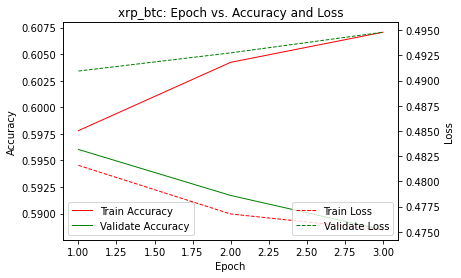

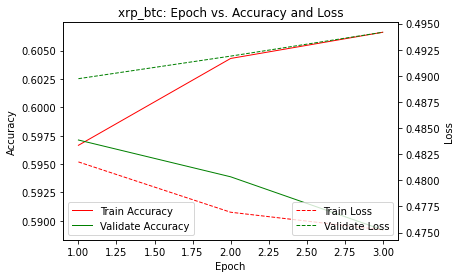

In [50]:
from pandas.plotting import table 
source_df = pd.DataFrame(m.run_data)
display(source_df)
record = {
    'xrp_btc': [],
}
data_set = 'xrp_btc'
    
df = source_df.loc[source_df.data_set == data_set]

for run_i in df['run'].unique():
    run_data = df.loc[df.run == run_i]
    epochs = run_data.epoch.values

    # Accuracy 1st y-axis
    fig, ax1 = plt.subplots()

    # Loss 2nd y-axis
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    colors = ['red', 'green', 'blue']

    for phase_i, phase in enumerate(['train', 'validate']):

        accuracy = run_data[f'{phase} accuracy'].values

        # record record
        if phase == 'validate':
            record[data_set].append({
                'max_accuracy': np.max(accuracy).round(3),
                'epoch': np.where(accuracy == np.max(accuracy))[0] + 1,

#                 'run': run_i
            })
#             for variable in variables:
#                 record[data_set][-1][variable] = run_data[variable].values[0]

        loss = run_data[f'{phase} loss'].values
        phase_accuracy, = ax1.plot(epochs, accuracy, 
             color=colors[phase_i],   
             linewidth=1.0
        )
        phase_accuracy.set_label(f"{phase.capitalize()} Accuracy")

        phase_loss, = ax2.plot(epochs, loss, 
             color=colors[phase_i],   
             linewidth=1.0,
             linestyle='--' 
        )
        phase_loss.set_label(f"{phase.capitalize()} Loss")

    ax1.legend(loc='lower left')
    ax2.legend(loc='lower right')

    x_label = "Epoch"
#     for variable in variables:
#         x_label += f"\n{variable} = {run_data[variable].values[0]}"
    ax1.set_xlabel(x_label)
    ax1.set_ylabel("Accuracy")
    ax2.set_ylabel("Loss")

    plt.title(f"{run_data['data_set'].values[0]}: Epoch vs. Accuracy and Loss")

#     ax1.set_ybound(lower=0.5, upper=.8)

    save_string = "sigma_relationship.png"
#     for variable in variables:
#         save_string = f"{data_set}_{variable}_{run_data[variable].values[0]}_" + save_string
#     plt.savefig(f"./{variables[0]}/" + save_string, bbox_inches='tight')
    plt.show()
#     break

[array([[7066,  180],
       [4438,  250]])]
[[7066  180]
 [4438  250]]
Normalized Confusion Matrix (Run #2)


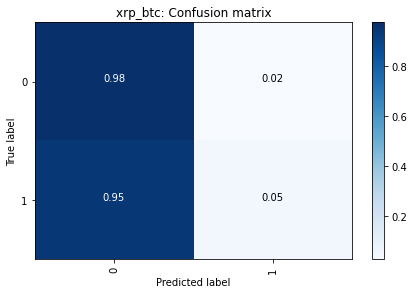

In [51]:
from copy import deepcopy
source_df = pd.DataFrame(m.run_data)

def plot_confusion_matrix(df_row, normalize=True, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(df_row.confusion_matrix.values)
    cm = deepcopy(df_row.confusion_matrix.values[0])
    classes = range(2) #df_row['label_subset'].values[0]
    print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print(f"Normalized Confusion Matrix (Run #{df_row.run.values[0]})")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
#     new = [[] for class_ in range(len(classes))]
#     print(new[0])
#     for row_i, row in enumerate(cm):
#         for col_i, col in enumerate(row):
#             print(row, col)
#             print(row_i, col_i)
#             print(col.item(), row.sum().item(), round(col.item() / row.sum().item(), 2))
#             new[row_i].append(round(col.item() / row.sum().item(), 2))
#             print(new)
#             print()
#         print()
    
#     cm = np.asarray(new)
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(f'{df_row.data_set.values[0]}: Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

    x_label = "Predicted label"
#     for variable in variables:
#         x_label += f"\n{variable} = {df_row[variable].values[0]}"
    plt.xlabel(x_label)
    
    save_string = "confusion_matrix.png"
#     for variable in variables:
#         save_string = f"{data_set}_{variable}_{df_row[variable].values[0]}_" + save_string
#     plt.savefig(f"./{variables[0]}/" + save_string, bbox_inches='tight')
        
    plt.show()
    
    
for data_set in list(source_df.data_set.unique()):
    df = source_df.loc[source_df.data_set == data_set]
#     display(df)
    for run_i in df['run'].unique():
        final_epoch_df = df.loc[df.run == run_i][-1:]
#         print(final_epoch_df.confusion_matrix)
#         plot_confusion_matrix(final_epoch_df)#, variables)
#         break
#     break
plot_confusion_matrix(df.tail(1))